---
**Finite Difference Methods**

Week 19 of EMAT30008

https://engmaths.github.io/emat30008/pdes/finite_diff/

(See scicomp/odefunctions.py for associated functions)

Author: Ben Winstanley, yy23737@bristol.ac.uk

---

In [45]:
import numpy as np
from scipy.optimize import root
import matplotlib.pyplot as plt

Goal: Create BVP solver to find solutions to ODEs of form:

$D \frac{d^2 u}{d x^2} + q(x,u:\mu) = 0$

over domain $a \leq x \leq b$, $D > 0$

Solver should handle Dirichlet, Neumann and Robin boundary conditions

Should be compatible with numerical continuation to track how $u(x)$ changes with $\mu$

Should be option to solve with linalg solve or with scipy root

-----------------
Q1: 
Use finite differences to solve
$\frac{d^2 u}{dx^2} = 0, u(a)=\gamma_1, u(b)=\gamma_2$:

We use N many gridpoints, $x_0 = a$, $x_N = b$, $i=0,1,2, \dots ,N-1,N$

Then our grid step is $\Delta x = \frac{b-a}{N}$

We solve:

$u_0 = a$

$\frac{u_{i+1} - 2u_i + u_{i-1}}{(\Delta x)^2}$

$u_N = b$

This becomes solving the matrix equation:

$A^{DD} \vec{u} = -\vec{b}^{DD}$

This would have dimension N-1 for b^DD

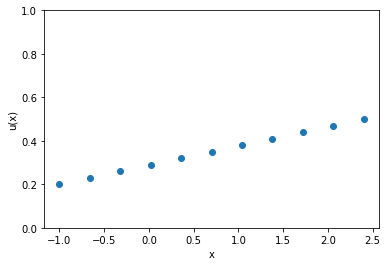

In [34]:
# Choose problem values
a = -1
gamma_1 = 0.2
b = 2.4
gamma_2 = 0.5

# Choose grid size
N = 10
x_vals = np.linspace(a,b,N+1)
delta_x = (b-a)/N

# Construct b^DD with zero plus end points
b_dd = np.zeros([N-1])
b_dd[0] = gamma_1
b_dd[-1] = gamma_2

# Construct A_dd with zeros plus diagonals
A_dd = -2*np.eye(N-1,k=0) + np.eye(N-1,k=1) + np.eye(N-1,k=-1)

# Solve A_dd u = -b_dd with linalg solve
u_interior = np.linalg.solve(A_dd, -b_dd)
# Add interior points to boundary
u = np.concatenate(([gamma_1], u_interior, [gamma_2]))

# Plotting to check
plt.scatter(x_vals,u)
plt.xlabel("x")
plt.ylim([0,1])
plt.ylabel("u(x)")
plt.show()

----------------
Q2: 

Add a prescribed source term q(x)

$A^{DD} \vec{u}(x) = -\vec{b}^{DD} -(\Delta x)^2 q(x)$

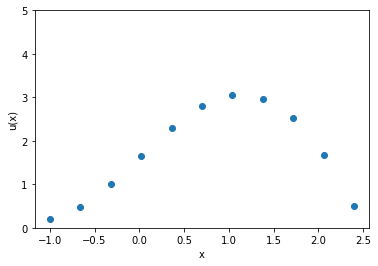

In [44]:
# Add source term q(x) in:
def q_func(x):
    return np.sin(x)

# Establish diffusivity constant D
D = 0.3

# Equation becomes A_dd u = - b_dd - (delta x)^2 q(x)

q_vals = q_func(x_vals)
q_vals_interior = q_vals[1:-1]

# Solve
rhs_vec = -b_dd - ((delta_x**2)/D)*q_vals_interior
u_interior = np.linalg.solve(A_dd, rhs_vec)

u = np.concatenate(([gamma_1], u_interior, [gamma_2]))

# Plotting to check
plt.scatter(x_vals,u)
plt.xlabel("x")
plt.ylim([0,5])
plt.ylabel("u(x)")
plt.show()

-----------------
Q3:

Add dependence on q(u) to make the equation nonlinear

Our equation is:

$A^{DD} \vec{u} = -\vec{b}^{DD} -\frac{(\Delta x)^2}{D} q(\vec u)$

Then we want to find the root of the function:

$F(\vec u) = A^{DD} \vec{u} + \vec{b}^{DD} + \frac{(\Delta x)^2}{D} q(\vec u)$

We define this objective function then use scipy root to find the solution



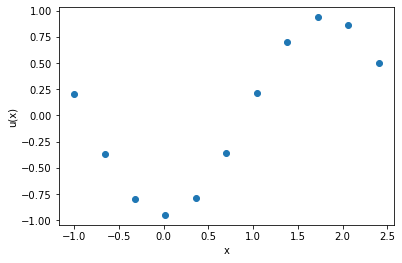

In [49]:
# Using same q function but it is now q(u)

def objective(u:np.ndarray):
    q_vals_interior = q_func(u)
    F = np.matmul(A_dd, u) + b_dd + ((delta_x**2)/D)*q_vals_interior
    return F

# Define initial solution guess for root finding which is a line between boundary points
u_guess_full = np.linspace(gamma_1,gamma_2,N+1)
u_guess = u_guess_full[1:-1] # Take the interior

# Solve with root
solution = root(objective, u_guess)
u_interior = solution.x

# Add boundaries
u = np.concatenate(([gamma_1], u_interior, [gamma_2]))

# Plotting to check
plt.scatter(x_vals,u)
plt.xlabel("x")
plt.ylabel("u(x)")
plt.show()

Solving the Bratu problem:

$q(u) = e^{u\mu}, 
a=0, b=1,
 \gamma_1=\gamma_2=0,
 D=1, \mu=0.1$


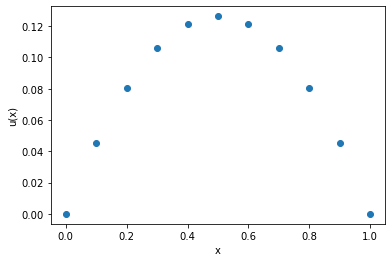

In [53]:
a,b = 0,1
gamma_1, gamma_2 = 0, 0
D = 1

# Choose grid size
N = 10
x_vals = np.linspace(a,b,N+1)
delta_x = (b-a)/N

# Construct b^DD with zero plus end points
b_dd = np.zeros([N-1])
b_dd[0] = gamma_1
b_dd[-1] = gamma_2

# Construct A_dd with zeros plus diagonals
A_dd = -2*np.eye(N-1,k=0) + np.eye(N-1,k=1) + np.eye(N-1,k=-1)

def q_func(u):
    mu = 0.1
    return np.exp(mu * u)

def objective(u:np.ndarray):
    q_vals_interior = q_func(u)
    F = np.matmul(A_dd, u) + b_dd + ((delta_x**2)/D)*q_vals_interior
    return F

# Define initial solution guess for root finding which is a line between boundary points
# As suggested we start with the solution for small mu where q is effectively 1:
def guess_function(x):
    return (-1/(2*D))*(x-a)*(x-b) + ((gamma_2-gamma_1)/(b-a))*(x-a) + gamma_1

u_guess_full = guess_function(x_vals)
u_guess = u_guess_full[1:-1]

# Solve with root
solution = root(objective, u_guess)
u_interior = solution.x

# Add boundaries
u = np.concatenate(([gamma_1], u_interior, [gamma_2]))

# Plotting to check
plt.scatter(x_vals,u)
plt.xlabel("x")
plt.ylabel("u(x)")
plt.show()

----------------
Question 4:

Before generalising we set up the problem with a Neumann and a Robin boundary on one side

Neumann boundary:

$u(a) = \alpha , \frac{du}{dx}[x=b] =  \delta $

We use the method of ghost points and extend the grid to include ghost point $x_{N+1}$

This alters our matrix A and vector b

Our root finding solution then includes physical end point $x_N$, and we add the left boundary only $u(a) = \alpha $ to the start

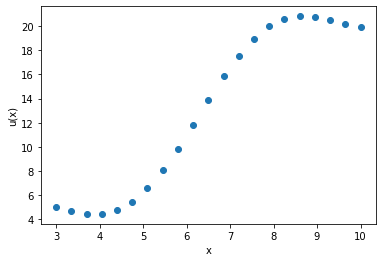

In [61]:
a = 3
b = 10
alpha = 5
delta = -0.3
D = 0.3

# Choose grid size
N = 20
x_vals = np.linspace(a,b,N+1)
delta_x = (b-a)/N

# Construct b^dn with zero plus end points, 1 more entry
b_dn = np.zeros([(N-1) + 1])
b_dn[0] = alpha
b_dn[-1] = 2*delta*delta_x

# Construct A_dn with zeros plus diagonals, altered for neumann
A_dn = -2*np.eye(N,k=0) + np.eye(N,k=1) + np.eye(N,k=-1)
A_dn[-1,-2] = 2

def q_func(x):
    return np.sin(x)

q_vals = q_func(x_vals)
q_vals_interior = q_vals[1:]

rhs_vec = -b_dn - ((delta_x**2)/D)*q_vals_interior
u_interior = np.linalg.solve(A_dn, rhs_vec)

u = np.concatenate(([alpha], u_interior))
                   
# Plotting to check
plt.scatter(x_vals,u)
plt.xlabel("x")
plt.ylabel("u(x)")
plt.show()

Robin boundary (mixed):

$u(a) = \alpha , \frac{du}{dx}[x=b] =  \delta - \gamma u(b)$

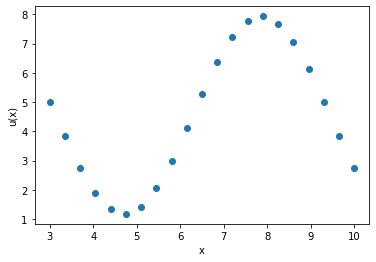

In [63]:
a = 3
b = 10
alpha = 5
delta = 0
gamma = 1
D = 0.3

# Choose grid size
N = 20
x_vals = np.linspace(a,b,N+1)
delta_x = (b-a)/N

# Construct b^dr with zero plus end points, 1 more entry
b_dr = np.zeros([(N-1) + 1])
b_dr[0] = alpha
b_dr[-1] = 2*delta*delta_x

# Construct A_dr with zeros plus diagonals, altered for neumann
A_dr = -2*np.eye(N,k=0) + np.eye(N,k=1) + np.eye(N,k=-1)
A_dr[-1,-2] = 2
A_dr[-1,-1] = -2*(1+gamma*delta_x)

def q_func(x):
    return np.sin(x)

q_vals = q_func(x_vals)
q_vals_interior = q_vals[1:]

rhs_vec = -b_dr - ((delta_x**2)/D)*q_vals_interior
u_interior = np.linalg.solve(A_dr, rhs_vec)

u = np.concatenate(([alpha], u_interior))
                   
# Plotting to check
plt.scatter(x_vals,u)
plt.xlabel("x")
plt.ylabel("u(x)")
plt.show()


Update to do this with Dirichlet, Neumann or Robin b.c.s. Generalise code

- We note that Neumann, Robin and Dirichlet boundary conditions only affect the matrix A and vector b
- Need functionality to include q, and indicate whether q acts on x or u
- If nonlinear we pass on q function into an objective function defined inside
- If nonlinear we require an initial solution guess: we set a default guess to be the line connecting the boundaries

In [ ]:
def finite_diff_bvp_solver(num_grid_points,
                           grid_bounds,
                           left_boundary_type, left_boundary_vals, 
                           right_boundary_type, right_boundary_vals,
                           q_func = None,
                           q_nonlinear = False,
                           guess_function = False,
                           ):
    '''
    Insert extensive docstring here
    '''
    N = num_grid_points
    a, b = grid_bounds

    # Establish x grid
    x_vals = np.linspace(a,b,N+1)
    delta_x = (b-a)/N

    # Calculate number of interior grid points based on boundary conditions
    N_interior = N-1
    x_vals_interior = x_vals
    if left_boundary_type != 'Dirichlet':
        N_interior += 1  # Include additional ghost point (on left)
        x_vals_interior = x_vals_interior[1:]
    if right_boundary_type != 'Dirichlet':
        N_interior += 1  # Include additional ghost point (on right)
        x_vals_interior = x_vals_interior[:-1]
    
    # Initialise b_vec and A_matrix
    b_vec = np.zeros([N_interior])
    A_matrix = -2*np.eye(N_interior,k=0) + np.eye(N_interior,k=1) + np.eye(N_interior,k=-1)
    
    # Treat left boundary
    if left_boundary_type == 'Dirichlet':
        b_vec[0] = left_boundary_vals[0]
    elif left_boundary_type == 'Neumann':
        b_vec[0] = -left_boundary_vals[0]*2*delta_x
        A_matrix[0,1] = 2
    elif left_boundary_type == 'Robin':
        b_vec[0] = -left_boundary_vals[0]*2*delta_x
        A_matrix[0,1] = 2
        A_matrix[0,0] = -2*(1+delta_x*left_boundary_vals[1])

    # Treat right boundary
    if right_boundary_type == 'Dirichlet':
        b_vec[-1] = right_boundary_vals[0]
    elif right_boundary_type == 'Neumann':
        b_vec[-1] = right_boundary_vals[0]*2*delta_x
        A_matrix[-1,-2] = 2
    elif right_boundary_type == 'Robin':
        b_vec[-1] = right_boundary_vals[0]*2*delta_x
        A_matrix[-1,-2] = 2
        A_matrix[-1,-1] = -2*(1+delta_x*right_boundary_vals[1])

    # If no source term q then call linalg to solve
    if q_func == None:
        u_interior = np.linalg.solve(A_matrix, -b_vec)

    # If source term q then split by linear or nonlinear
    if not q_nonlinear:
        # Calculate fixed q(x)
        q_vals_interior = q_func(x_vals_interior)

        # Solve with linalg solve
        rhs_vec = -b_vec - ((delta_x**2)/D)*q_vals_interior
        u_interior = np.linalg.solve(A_matrix, rhs_vec)

    elif q_nonlinear:
        # Define objective function to minimise
        def objective(u:np.ndarray):
            q_vals_interior = q_func(u)
            F = np.matmul(A_matrix, u) + b_vec + ((delta_x**2)/D)*q_vals_interior
            return F
        
        # Establish initial guess solution via a function
        # If guess solution function isn't supplied then make one
        if guess_function == None:
            # If both Dirichlet bounds given:
            if (left_boundary_type == 'Dirichlet') and (right_boundary_type = 'Dirichlet'):
                # Establish function connecting both points
                def guess_function(x):
                    return left_boundary_vals[0] + ((right_boundary_vals[0]-left_boundary_vals[0])/(b-a))*(x-a)
            elif left_boundary_type == 'Dirichlet':
                # Establish function with constant left boundary value
                def guess_function(x):
                    return left_boundary_vals[0]
            elif right_boundary_type == ' Dirichlet':
                # Establish function with constant right boundary value
                def guess_function(x):
                    return right_boundary_vals[0]
            else:
                # Establish function f(x) = 1
                def guess_function(x):
                    return 1
        
        # Calculate guess solution
        u_guess = guess_function(x_vals_interior)
        
        


            
            
        else:
            # Use supplied guess function to establish guess solution

        
    
    # Add prescribed boundary points if Dirichlet